# Przetwarzanie obrazów CPSO

Grupa: Mikołaj Baran 241128, Jakub Fałdasz 235730 <br>
Termina zajęć: Czwartek, 7:30-9:00 TN


In [13]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def show_img(image_obj, title, gray=False):
    if gray:
        plt.imshow(image_obj, cmap='gray')
    else:
        plt.imshow(image_obj)
    plt.title(title)
    plt.show()

# Zadanie 5

W piątym zadaniu należy utworzyć skrypt umożliwiający wczytanie i wizualizację badanych obrazów poprzez podanie ścieżki do pliku z obrazem. Dodatkowo użytkownik powinien móc wybrać mniejszy prostokątny obszar wczytanego obrazu o zadanych współrzędnych oraz jego zapis do pliku.

Do wczytania i manipulacji obrazem zostanie wykorzystana biblioteka `OpenCV`.

Wczytane obrazki zostaną wyświetlone przy pomocy biblioteki `matplotlib`, jednak aby zrobić to poprawnie należy przekonwertować obrazy wczytane przy użyciu `OpenCV` w formacie `BGR` do formatu `RGB`, który jest obsługiwany przez `matplotlib`.

Podaj ścieżkę do obrazu: 


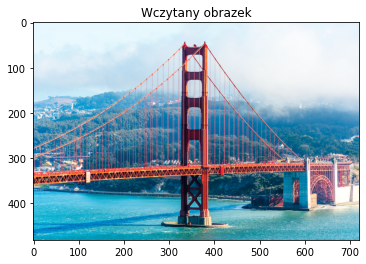

In [14]:
path = input("Podaj ścieżkę do obrazu: ")
if(path == ""):
    path = 'golden_gate.png'
img_bgr = cv2.imread(path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

show_img(img_rgb, "Wczytany obrazek")

Następnie użytkownik może wybrać interesujący go fragment obrazu poprzez podanie jego `wysokości`, `szerokości` i `punktu początkowego obrazu` (zakładając, że punkt [0,0] jest w lewym górnym rogu układu), który zostanie zapisany w wybranym przez użytkownika pliku.

In [15]:
choice = input('Czy chcesz zmienić wielkość wczytanego obrazu? (t / n): ')
choice = choice.lower()
while (choice != 't' and choice != 'n'):
    choice = input('Czy chcesz zmienić wielkość wczytanego obrazu? (t / n): ')
    choice = choice.lower()
    
if choice == 't':
    wrong_input = True
    while(wrong_input):
        try:
            height = int(input("Podaj wysokość wycinka obrazka: "))
            width = int(input("Podaj szerokość wycinka obrazka: "))
            start_x = int(input("Podaj współrzędną x punktu startowego wycinka: "))
            start_y = int(input("Podaj współrzędną y punktu startowego wycinka: "))
        except ValueError:
            print("Musisz podać liczbę!")
            continue
        
        if height + start_y > img_rgb.shape[0] or width + start_x > img_rgb.shape[1] or start_x < 0 or start_y < 0:
            wrong_input = True
            print("\nPodano niepoprawne wymiary.\n")
        else:
            wrong_input = False
    cropped_image = img_rgb[start_y:start_y+height, start_x:start_x+width]
    image_to_save = input("Podaj nazwę pliku do zapisu nowego obrazka: ")
    cv2.imwrite(image_to_save, cropped_image)
    
    show_img(cropped_image, "Wcyinek obrazka")
    
    choice = input('Czy w kolejnych zadaniach chcesz używać utworzonego wycinka? (t / n): ')
    choice.lower()
    while (choice != 't' and choice != 'n'):
        choice = input()
        choice.lower()
        
    if(choice == 't'):
        img = cropped_image
    elif(choice == 'n'):
        img = img_rgb
elif choice == 'n':
    img = img_rgb

Czy chcesz zmienić wielkość wczytanego obrazu? (t / n): n


# Zadanie 6

W kolejnym zadaniu należy przeprowadzić na wczytanym obrazku przekształcenia punktowe `T` wg wzoru `s = T(r)`, gdzię `r`,`s`, oznaczają odpowiednio poziom szarości piksela obrazu wejściowe i wyjściowego.

Pierwszą rzeczą jaką należy zrobić jest przekształcenie wczytanego obrazu do skali szarości. Następnie każdy piksel obrazka zostanie pomnożony przez stałą `c` podaną przez użytkownika.

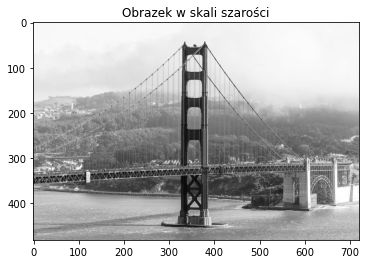

Podaj stałą c: 6


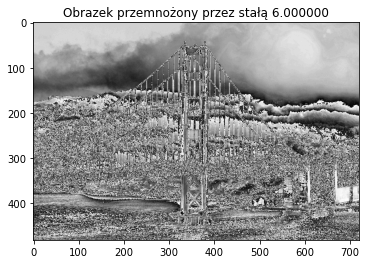

In [16]:
img_gs = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
show_img(img_gs, "Obrazek w skali szarości", gray=True)

try:
    c = float(input("Podaj stałą c: "))
except:
    c = 1
    
img_multiplied = img_gs * c
img_multiplied = img_multiplied.astype('uint8')
show_img(img_multiplied, "Obrazek przemnożony przez stałą %f" % c, gray=True)




Następnie możemy zastosować zmianę dynamiki skali szarości (kontrastu) wg poniższego wzoru, gdzie m i e są parametrami ustalonymi przez użytkownika:

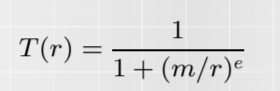

Dodatkowo na wykresie został wykreślone `T(r)`, aby ukazać wpływ T na kontrast obrazu wyjściowego.

Funkcja `contrast(image, m, e):` zwraca obraz ze zmienionym kontrastem oraz przekształcenie poziomów szarości w tablicy `LUT` obliczonych z powyższego wzoru. 

Podaj parametr m: 4
Podaj parametr e: 4


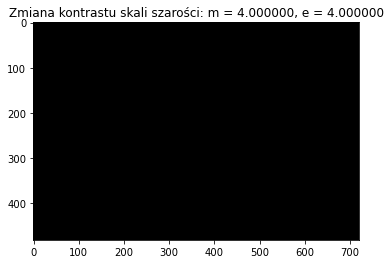

Text(0.5, 1.0, 'Wpływ T na kontrst obrazu wyjściowego m = 4.000000, e = 4.000000')

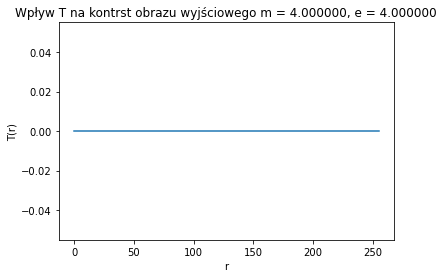

In [17]:
def contrast(image, m, e):
    LUT = np.empty((1, 256), np.uint8)
    LUT[0,0] = 0
    for i in range(1, 256):
        LUT[0, i] = np.clip(255*(1/(1+pow(m/(i/255), e))), 0, 255)
    return (cv2.LUT(image, LUT), LUT[0])

try:
    m = float(input('Podaj parametr m: '))
    e = float(input('Podaj parametr e: '))
except:
    m = 1
    e = 1

contrasted, LUT = contrast(img_gs, m, e)
show_img(contrasted, "Zmiana kontrastu skali szarości: m = %f, e = %f"% (m, e), gray=True)

plt.plot(range(0, 256), LUT)
plt.xlabel('r')
plt.ylabel('T(r)')
plt.title("Wpływ T na kontrst obrazu wyjściowego m = %f, e = %f" % (m,e))


W kolejnej częsci zadania należało przeprowadzić korekcję gamma, zdefiniowaną $s = c * r^\gamma$, gdzie $c > 0$ i $\gamma > 0$ sa stałymi we wzorze przekształcenia.

Podaj parametr c: 3
Podaj parametr gamma: 3


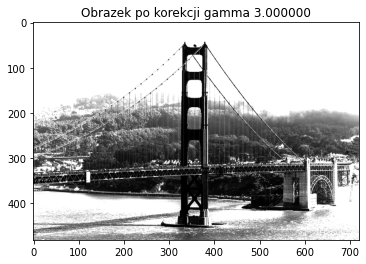

In [18]:
def gamma_correct(image, c, gamma):
    LUT = np.empty((1, 256), np.uint8)
    LUT[0,0] = 0
    for i in range(1, 256):
        LUT[0, i] = np.clip(255*(pow(i/255, gamma)*c), 0, 255)
    return cv2.LUT(image, LUT)

try:
    c = abs(float(input('Podaj parametr c: ')))
    gamma = abs(float(input('Podaj parametr gamma: ')))
except:
    c = 1
    gamma = 1
    
img_gamma = gamma_correct(img_gs, c, gamma)
show_img(img_gamma, "Obrazek po korekcji gamma %f" % c, gray=True)


#  Ćwiczenie 7

W zadaniu 7 zostanie przeprowadzone `wyrównanie histogramu` w celu ukazaniu różnicy w obrazkach, w których dystrybujca wartości pikseli na histogramie zostanie rozcągnięta podobnie jak na poniższym obrazku.
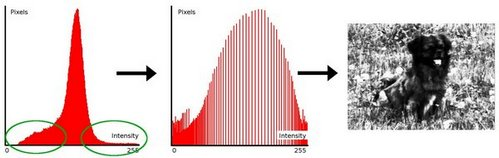

Zostanie wykorzystana do tego funkcja udostępniona przez biblioteke OpenCV `equalizeHist()`.

Poniżej widzimy wyrównanie histogramu wczytanego przez nas obrazka oraz histogramy obrazków przed i po wyrównaniu.

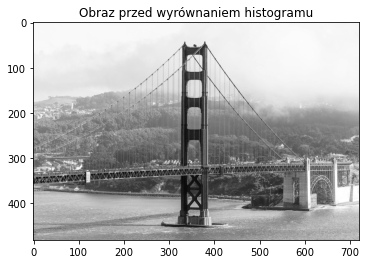

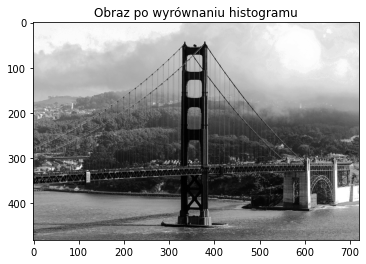

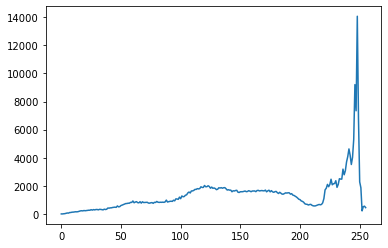

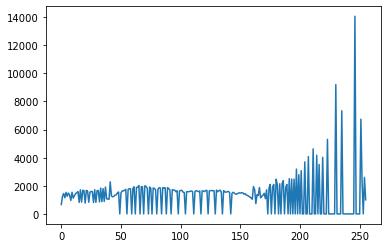

In [30]:
img_eq = cv2.equalizeHist(img_gs)

show_img(img_gs, "Obraz przed wyrównaniem histogramu", gray=True)
show_img(img_eq, "Obraz po wyrównaniu histogramu", gray=True)

histg_before = cv2.calcHist([img_gs], [0], None, [256], [0, 256])
histg_after = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(1)
plt.plot(histg_before)
plt.figure(2)
plt.plot(histg_after)

Teraz dla zbyt ciemnego obrazka. 



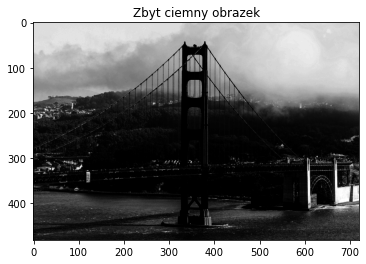

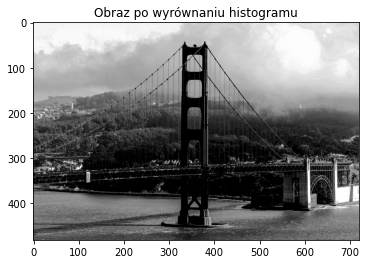

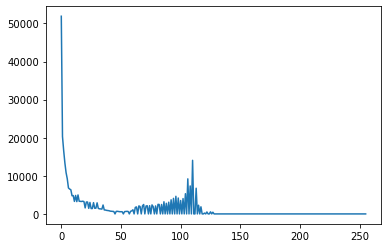

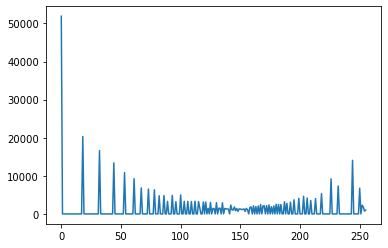

In [31]:
img_gamma = gamma_correct(img_gs, 0.5, 5)
img_eq = cv2.equalizeHist(img_gamma)

show_img(img_gamma, "Zbyt ciemny obrazek", gray=True)
show_img(img_eq, "Obraz po wyrównaniu histogramu", gray=True)

histg_before = cv2.calcHist([img_gamma], [0], None, [256], [0, 256])
histg_after = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(1)
plt.plot(histg_before)
plt.figure(2)
plt.plot(histg_after)

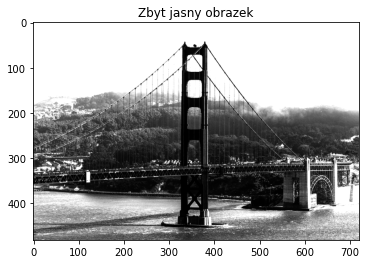

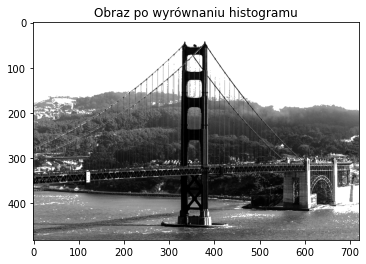

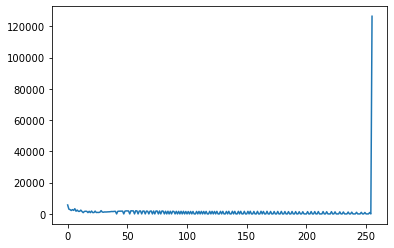

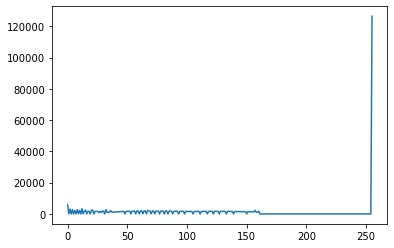

In [32]:
img_gamma = gamma_correct(img_gs, 2, 3)
img_eq = cv2.equalizeHist(img_gamma)

show_img(img_gamma, "Zbyt jasny obrazek", gray=True)
show_img(img_eq, "Obraz po wyrównaniu histogramu", gray=True)

histg_before = cv2.calcHist([img_gamma], [0], None, [256], [0, 256])
histg_after = cv2.calcHist([img_eq], [0], None, [256], [0, 256])

plt.figure(1)
plt.plot(histg_before)
plt.figure(2)
plt.plot(histg_after)